In [1]:
import pandas as pd

In [2]:
print("Pandas version:", pd.__version__)

Pandas version: 2.3.3


In [3]:
%matplotlib inline

In [4]:
import numpy as np
import pandas as pd

import anndata as ad
import scanpy as sc
import squidpy as sq

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

# load the pre-processed dataset
img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata()

/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None t

squidpy==1.6.5


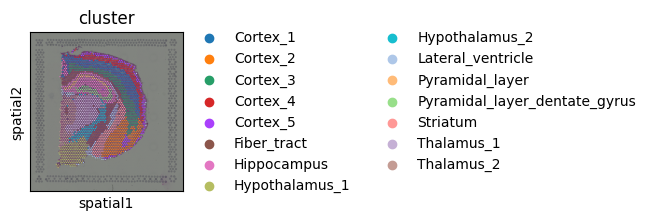

In [5]:
sq.pl.spatial_scatter(adata, color="cluster")

In [6]:
# calculate features for different scales (higher value means more context)
for scale in [1.0, 2.0]:
    feature_name = f"features_summary_scale{scale}"
    sq.im.calculate_image_features(
        adata,
        img.compute(),
        features="summary",
        key_added=feature_name,
        n_jobs=4,
        scale=scale,
    )


# combine features in one dataframe
adata.obsm["features"] = pd.concat(
    [adata.obsm[f] for f in adata.obsm.keys() if "features_summary" in f],
    axis="columns",
)
# make sure that we have no duplicated feature names in the combined table
adata.obsm["features"].columns = ad.utils.make_index_unique(
    adata.obsm["features"].columns
)

  0%|          | 0/2688 [00:00<?, ?/s]/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration o

/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")
/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():
/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/_0/j8xw5t8j6p3dg7_fq82t36gr0000gp/T/ipykernel_61249/3320298302.py:18:

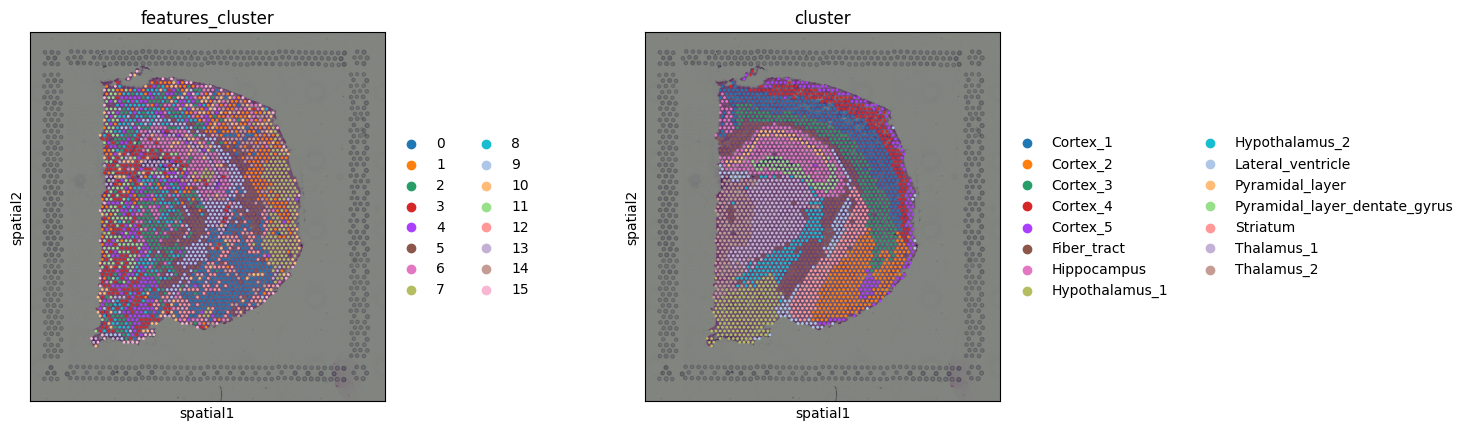

In [7]:
# helper function returning a clustering
def cluster_features(features: pd.DataFrame, like=None) -> pd.Series:
    """
    Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata.obs["leiden"]


# calculate feature clusters
adata.obs["features_cluster"] = cluster_features(adata.obsm["features"], like="summary")

# compare feature and gene clusters
sq.pl.spatial_scatter(adata, color=["features_cluster", "cluster"])

  0%|          | 0/1000 [00:00<?, ?/s]/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from 

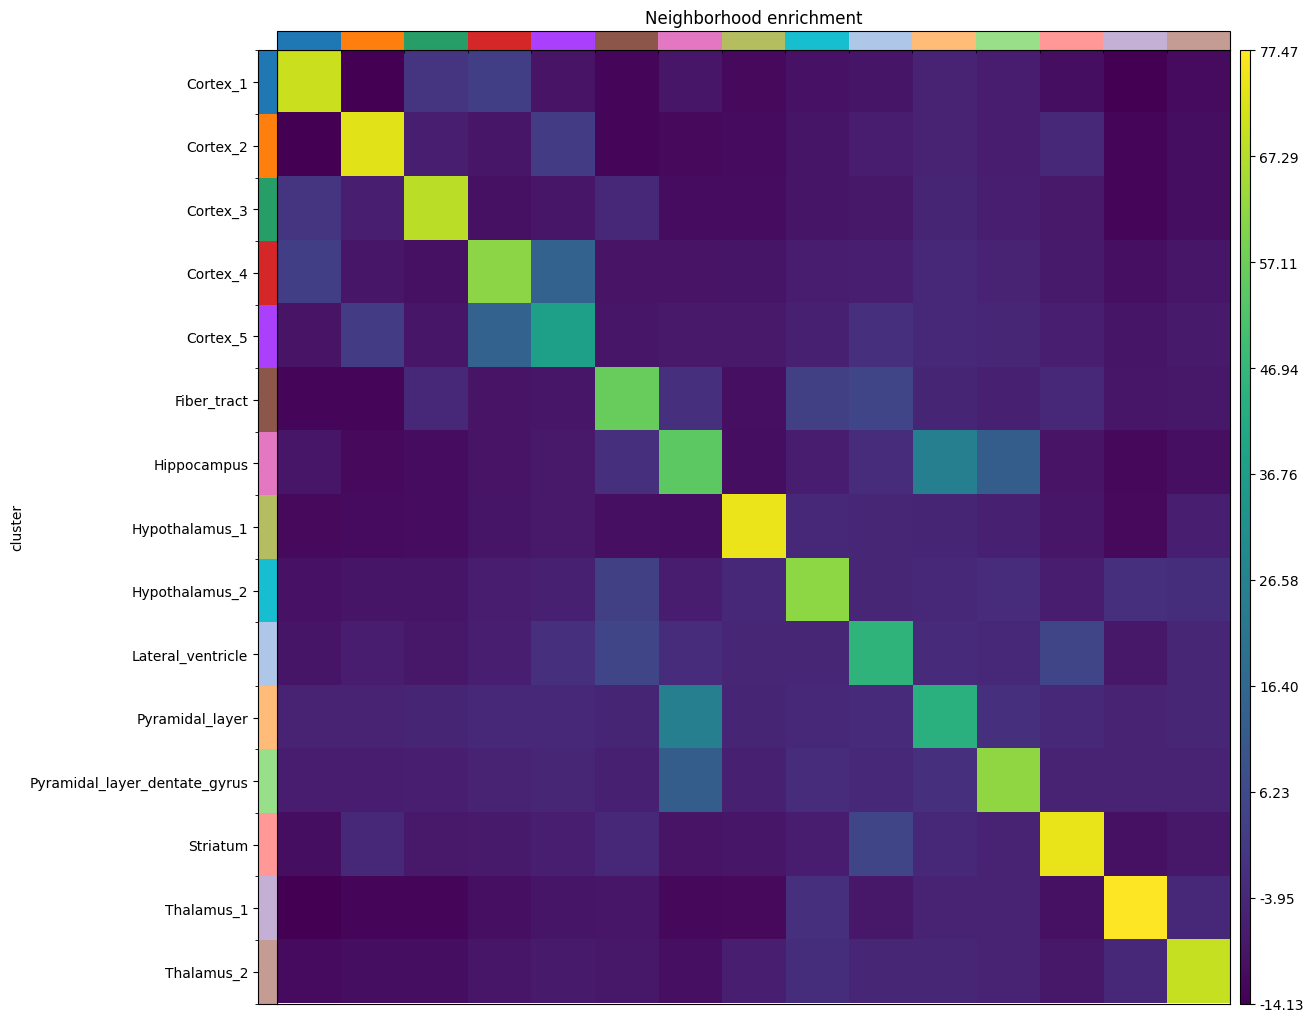

In [8]:
sq.gr.spatial_neighbors(adata)
sq.gr.nhood_enrichment(adata, cluster_key="cluster")
sq.pl.nhood_enrichment(adata, cluster_key="cluster")

  0%|          | 0/1 [00:00<?, ?/s]/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from ann

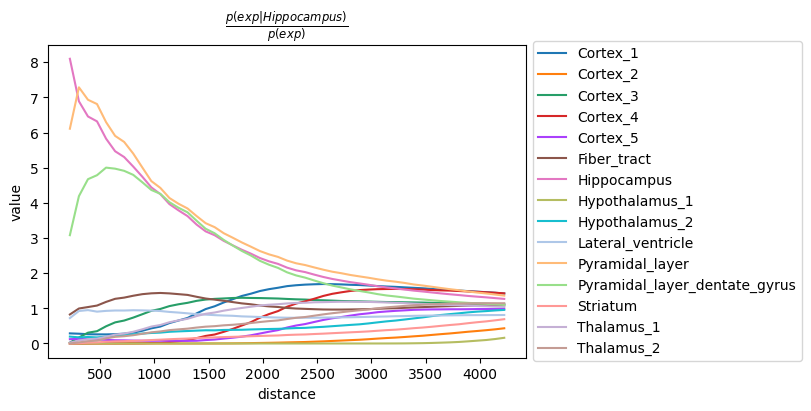

In [9]:
sq.gr.co_occurrence(adata, cluster_key="cluster")
sq.pl.co_occurrence(
    adata,
    cluster_key="cluster",
    clusters="Hippocampus",
    figsize=(8, 4),
)

In [14]:
sq.gr.ligrec(
    adata,
    n_perms=100,
    cluster_key="cluster",
)

  0%|          | 0/100 [00:00<?, ?permutation/s]python(61551) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
python(61556) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_di

In [17]:
sq.pl.ligrec(
    adata,
    cluster_key="cluster",
    source_groups="Hippocampus",
    target_groups=["Pyramidal_layer", "Pyramidal_layer_dentate_gyrus"],
    means_range=(3, np.inf),
    alpha=1e-4,
    swap_axes=True,
)

/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/squidpy/pl/_ligrec.py:248: FutureWarning: Use uns (e.g. `k in adata.uns` or `sorted(adata.uns)`) instead of AnnData.uns_keys, AnnData.uns_keys is deprecated and will be removed in the future.
  if cluster_key not in adata.uns_keys():


ValueError: After removing rows with only NaN interactions, none remain.

In [11]:
genes = adata[:, adata.var.highly_variable].var_names.values[:1000]
sq.gr.spatial_autocorr(
    adata,
    mode="moran",
    genes=genes,
    n_perms=100,
    n_jobs=1,
)

  0%|          | 0/100 [00:00<?, ?/s]python(61529) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/_utils/__init__.py:33: FutureW

In [12]:
adata.uns["moranI"].head(10)

,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
Olfm1,0.763291,0.0,0.000131,0.0,0.009901,0.000367,0.0,0.0,0.011676
Plp1,0.747660,0.0,0.000131,0.0,0.009901,0.000280,0.0,0.0,0.011676
Itpka,0.727076,0.0,0.000131,0.0,0.009901,0.000258,0.0,0.0,0.011676
Snap25,0.720987,0.0,0.000131,0.0,0.009901,0.000290,0.0,0.0,0.011676
Nnat,0.708637,0.0,0.000131,0.0,0.009901,0.000295,0.0,0.0,0.011676
Ppp3ca,0.693320,0.0,0.000131,0.0,0.009901,0.000269,0.0,0.0,0.011676
Chn1,0.684957,0.0,0.000131,0.0,0.009901,0.000215,0.0,0.0,0.011676
Mal,0.679775,0.0,0.000131,0.0,0.009901,0.000283,0.0,0.0,0.011676
Tmsb4x,0.676719,0.0,0.000131,0.0,0.009901,0.000206,0.0,0.0,0.011676
Cldn11,0.674110,0.0,0.000131,0.0,0.009901,0.000266,0.0,0.0,0.011676


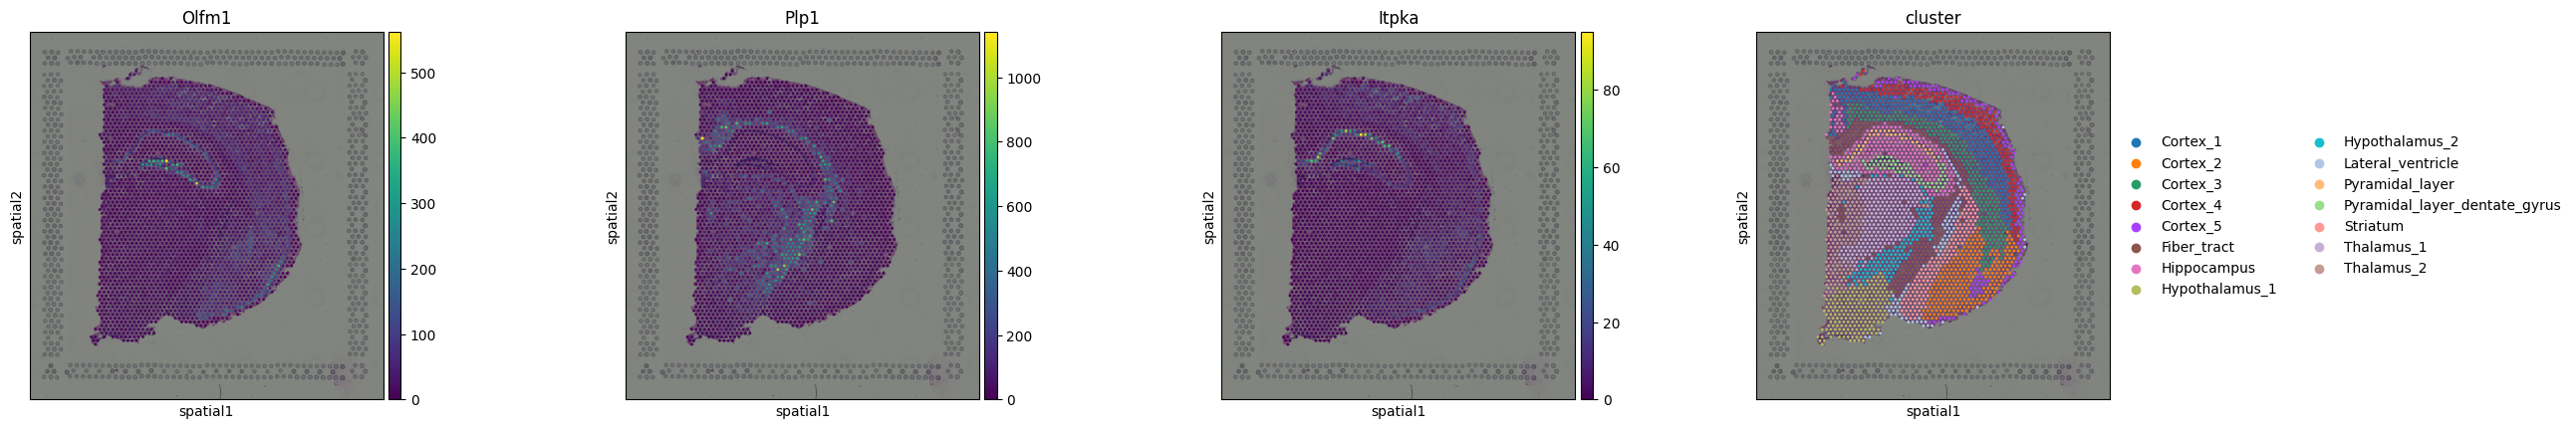

In [13]:
sq.pl.spatial_scatter(adata, color=["Olfm1", "Plp1", "Itpka", "cluster"])